In [2]:
# import torch
# print(torch.cuda.is_available())
# print(torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU detected")

In [ ]:
from sb3_contrib import MaskablePPO
from stable_baselines3.common.callbacks import EvalCallback
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.monitor import Monitor
import numpy as np
import torch
from environment3 import LifeStyleEnv
import gymnasium as gym
from sb3_contrib.common.wrappers import ActionMasker

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

def mask_fn(env: gym.Env) -> np.ndarray:
    unwrapped_env = env
    while hasattr(unwrapped_env, "env"):
        unwrapped_env = unwrapped_env.env
    return unwrapped_env.action_masks()

def make_env(is_eval: bool = False):
    env = LifeStyleEnv()
    env = Monitor(env)
    if not is_eval:
        check_env(env, warn=True) 
    return env

env = make_env()
env = ActionMasker(env, mask_fn)

eval_env = make_env(is_eval=True)
eval_env = ActionMasker(eval_env, mask_fn)

eval_callback = EvalCallback(
    eval_env,
    best_model_save_path="./logs/ppo/ppo_best_model",
    log_path="./logs/ppo/ppo_results",
    eval_freq=5000,
    n_eval_episodes=10,
    deterministic=True,
    render=False
)

model = MaskablePPO(
    "MultiInputPolicy",  
    env,
    learning_rate=0.0005,
    n_steps=512,
    batch_size=128,
    n_epochs=10,
    gamma=0.95,
    gae_lambda=0.95,
    clip_range=0.2,
    ent_coef=0.001,  
    vf_coef=0.5,
    max_grad_norm=0.5,
    verbose=1,
    device=device,
    policy_kwargs=dict(net_arch=[256, 256]),
    tensorboard_log="./logs/ppo/ppo_tensorboard/"
)

model.learn(
    total_timesteps=800000, 
    callback=eval_callback
)


Using device: cuda
Using cuda device
Wrapping the env in a DummyVecEnv.
Logging to ./logs/ppo/ppo_tensorboard/PPO_1
----------------------------
| time/              |     |
|    fps             | 587 |
|    iterations      | 1   |
|    time_elapsed    | 0   |
|    total_timesteps | 512 |
----------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 520         |
|    iterations           | 2           |
|    time_elapsed         | 1           |
|    total_timesteps      | 1024        |
| train/                  |             |
|    approx_kl            | 0.006931583 |
|    clip_fraction        | 0.103       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.77       |
|    explained_variance   | 6.79e-06    |
|    learning_rate        | 0.0005      |
|    loss                 | 1.21e+03    |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.0199     |
|    valu

In [ ]:
from environment3 import LifeStyleEnv
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.monitor import Monitor
from sb3_contrib.common.maskable.utils import get_action_masks
import numpy as np
from sb3_contrib import MaskablePPO

def make_env(is_eval: bool = False):
    env = LifeStyleEnv(days_per_episode = 365)
    env = Monitor(env)
    if not is_eval:
        check_env(env, warn=True)
    return env

eval_env = make_env(is_eval=True)

model = MaskablePPO.load("logs/ppo/ppo_best_model/best_model.zip")

print("Starting Final Evaluation...")
print("-------------------------------------------------------------------------------------------------------------------------------------")
print(f"| {'Day':<3} | {'Timeslot':<10} | {'Action':<10} | {'Event':<10} | {'BMI':<8} | {'Stress':<8} | {'Energy':<8} | {'Hunger':<8} | {'Cal. Intake':<12} | {'Cal. Burned':<12} | {'Reward':<8} |")
print("-------------------------------------------------------------------------------------------------------------------------------------")

episode_rewards = []
for episode in range(1):  
    obs, info = eval_env.reset()
    unwrapped_env = eval_env.unwrapped
    
    done = False
    total_reward = 0
    while not done:
        action_masks = get_action_masks(unwrapped_env)
        action, _ = model.predict(obs, deterministic=True, action_masks=action_masks)
        obs, reward, terminated, truncated, info = eval_env.step(action)
        done = terminated or truncated
        total_reward += reward
        
        timeslot_applied = unwrapped_env.state['current_timeslot'] - 1
        timeslot_applied = max(timeslot_applied, 0)  
        event_applied = unwrapped_env.daily_schedule[timeslot_applied]

        print(
            f"| {unwrapped_env.state['day_of_episode']:<3} | "
            f"{unwrapped_env.state['current_timeslot']:<10} | "
            f"{action:<10} | "
            f"{event_applied:<10} | "
            f"{unwrapped_env.state['current_bmi']:<8.2f} | "
            f"{unwrapped_env.state['current_stress_level']:<8.2f} | "
            f"{unwrapped_env.state['current_energy_level']:<8.2f} | "
            f"{unwrapped_env.state['current_hunger_level']:<8.2f} | "
            f"{unwrapped_env.state['daily_calories_intake']:<12.2f} | "
            f"{unwrapped_env.state['daily_calories_burned']:<12.2f} | "
            f"{reward:<8.2f} |"
        )
        
        episode_rewards.append(reward)

print("-------------------------------------------------------------------------------------------------------------------------------------")
print("Mean evaluation reward:", np.mean(episode_rewards))
print("Std deviation:", np.std(episode_rewards))

Starting Final Evaluation...
-------------------------------------------------------------------------------------------------------------------------------------
| Day | Timeslot   | Action     | Event      | BMI      | Stress   | Energy   | Hunger   | Cal. Intake  | Cal. Burned  | Reward   |
-------------------------------------------------------------------------------------------------------------------------------------
| 0   | 1          | 8          | sleep      | 24.22    | 46.00    | 54.00    | 48.00    | 0.00         | 66.15        | 1.11     |
| 0   | 2          | 8          | sleep      | 24.22    | 42.00    | 58.00    | 46.00    | 0.00         | 132.30       | 2.41     |
| 0   | 3          | 8          | sleep      | 24.22    | 38.00    | 62.00    | 44.00    | 0.00         | 198.45       | 3.69     |
| 0   | 4          | 8          | sleep      | 24.22    | 34.00    | 66.00    | 42.00    | 0.00         | 264.60       | 4.95     |
| 0   | 5          | 8          | sleep    

Contents of the NPZ file: ['timesteps', 'results', 'ep_lengths']


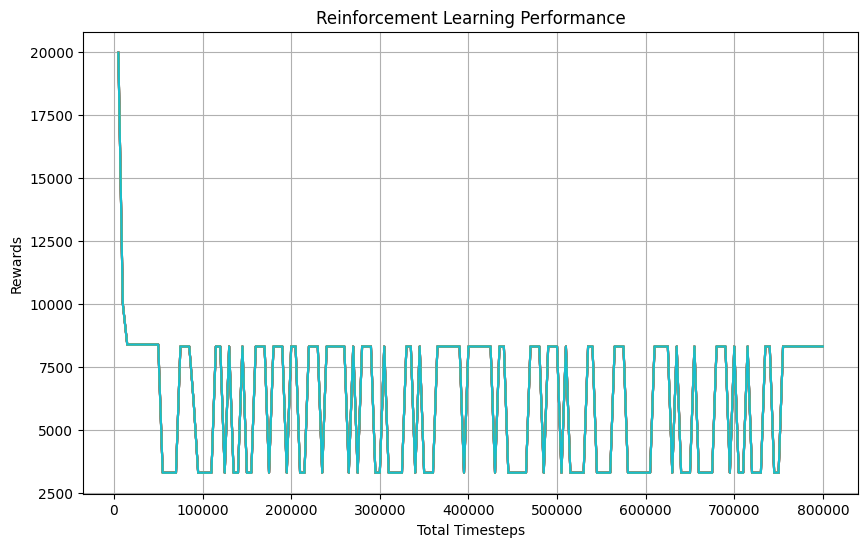

In [8]:
import numpy as np
import matplotlib.pyplot as plt

file_path = 'logs/ppo/ppo_results/evaluations.npz'

try:
    data = np.load(file_path)
    print(f"Contents of the NPZ file: {data.files}")
    timesteps = data['timesteps']
    results = data['results']

    plt.figure(figsize=(10, 6))
    plt.plot(timesteps, results)

    plt.title('Reinforcement Learning Performance')
    plt.xlabel('Total Timesteps')
    plt.ylabel('Rewards')
    plt.grid(True)

except FileNotFoundError:
    print(f"Error: The file '{file_path}' was not found.")
except KeyError as e:
    print(f"Error: The key {e} was not found in the NPZ file. Check the contents using data.files.")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

tensorboard --logdir ./logs/ppo/ppo_tensorboard/

In [1]:
from sb3_contrib import MaskablePPO
from stable_baselines3.common.callbacks import EvalCallback
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.monitor import Monitor
import numpy as np
import torch
from environment3 import LifeStyleEnv
import gymnasium as gym
from sb3_contrib.common.wrappers import ActionMasker

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

def mask_fn(env: gym.Env) -> np.ndarray:
    unwrapped_env = env
    while hasattr(unwrapped_env, "env"):
        unwrapped_env = unwrapped_env.env
    return unwrapped_env.action_masks()

def make_env(is_eval: bool = False):
    env = LifeStyleEnv(initial_weight_kg=45)
    env = Monitor(env)
    if not is_eval:
        check_env(env, warn=True) 
    return env

env = make_env()
env = ActionMasker(env, mask_fn)

eval_env = make_env(is_eval=True)
eval_env = ActionMasker(eval_env, mask_fn)

eval_callback = EvalCallback(
    eval_env,
    best_model_save_path="./logs/ppo/ppo_best_model_fined_tuned",
    log_path="./logs/ppo/ppo_results_fined_tuned",
    eval_freq=5000,
    n_eval_episodes=10,
    deterministic=True,
    render=False
)

model = MaskablePPO.load("logs/ppo/ppo_best_model/best_model.zip", env=env)

model.learn(
    total_timesteps=150000, 
    callback=eval_callback
)


2025-09-03 20:46:31.167879: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-09-03 20:46:31.199426: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-09-03 20:46:32.164024: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
Gym has been unmaintained since 2022 and does not support NumPy 2.0 

Using device: cuda
Wrapping the env in a DummyVecEnv.
Logging to ./logs/ppo/ppo_tensorboard/PPO_2
----------------------------
| time/              |     |
|    fps             | 508 |
|    iterations      | 1   |
|    time_elapsed    | 1   |
|    total_timesteps | 512 |
----------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 507         |
|    iterations           | 2           |
|    time_elapsed         | 2           |
|    total_timesteps      | 1024        |
| train/                  |             |
|    approx_kl            | 0.023911985 |
|    clip_fraction        | 0.203       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.606      |
|    explained_variance   | -0.000165   |
|    learning_rate        | 0.0005      |
|    loss                 | 1.42e+03    |
|    n_updates            | 100         |
|    policy_gradient_loss | -0.0227     |
|    value_loss           |

Contents of the NPZ file: ['timesteps', 'results', 'ep_lengths']


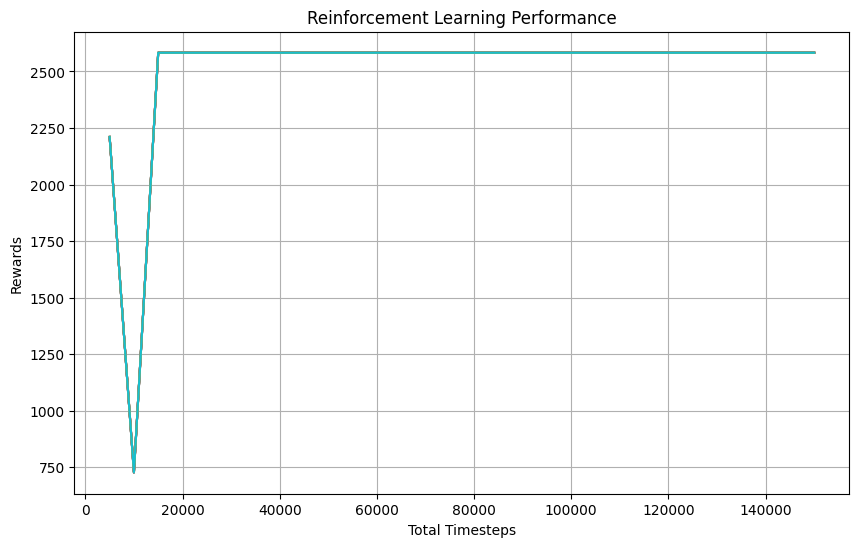

In [2]:
import numpy as np
import matplotlib.pyplot as plt

file_path = 'logs/ppo/ppo_results_fined_tuned/evaluations.npz'

try:
    data = np.load(file_path)
    print(f"Contents of the NPZ file: {data.files}")
    timesteps = data['timesteps']
    results = data['results']

    plt.figure(figsize=(10, 6))
    plt.plot(timesteps, results)

    plt.title('Reinforcement Learning Performance')
    plt.xlabel('Total Timesteps')
    plt.ylabel('Rewards')
    plt.grid(True)

except FileNotFoundError:
    print(f"Error: The file '{file_path}' was not found.")
except KeyError as e:
    print(f"Error: The key {e} was not found in the NPZ file. Check the contents using data.files.")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

In [4]:
from environment3 import LifeStyleEnv
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.monitor import Monitor
from sb3_contrib.common.maskable.utils import get_action_masks
import numpy as np
from sb3_contrib import MaskablePPO

def make_env(is_eval: bool = False):
    env = LifeStyleEnv(days_per_episode = 365, initial_weight_kg=45)
    env = Monitor(env)
    if not is_eval:
        check_env(env, warn=True)
    return env

eval_env = make_env(is_eval=True)

model = MaskablePPO.load("logs/ppo/ppo_best_model_fined_tuned/best_model.zip")

print("Starting Final Evaluation...")
print("-------------------------------------------------------------------------------------------------------------------------------------")
print(f"| {'Day':<3} | {'Timeslot':<10} | {'Action':<10} | {'Event':<10} | {'BMI':<8} | {'Stress':<8} | {'Energy':<8} | {'Hunger':<8} | {'Cal. Intake':<12} | {'Cal. Burned':<12} | {'Reward':<8} |")
print("-------------------------------------------------------------------------------------------------------------------------------------")

episode_rewards = []
for episode in range(1):  
    obs, info = eval_env.reset()
    unwrapped_env = eval_env.unwrapped
    
    done = False
    total_reward = 0
    while not done:
        action_masks = get_action_masks(unwrapped_env)
        action, _ = model.predict(obs, deterministic=True, action_masks=action_masks)
        obs, reward, terminated, truncated, info = eval_env.step(action)
        done = terminated or truncated
        total_reward += reward
        
        timeslot_applied = unwrapped_env.state['current_timeslot'] - 1
        timeslot_applied = max(timeslot_applied, 0)  
        event_applied = unwrapped_env.daily_schedule[timeslot_applied]

        print(
            f"| {unwrapped_env.state['day_of_episode']:<3} | "
            f"{unwrapped_env.state['current_timeslot']:<10} | "
            f"{action:<10} | "
            f"{event_applied:<10} | "
            f"{unwrapped_env.state['current_bmi']:<8.2f} | "
            f"{unwrapped_env.state['current_stress_level']:<8.2f} | "
            f"{unwrapped_env.state['current_energy_level']:<8.2f} | "
            f"{unwrapped_env.state['current_hunger_level']:<8.2f} | "
            f"{unwrapped_env.state['daily_calories_intake']:<12.2f} | "
            f"{unwrapped_env.state['daily_calories_burned']:<12.2f} | "
            f"{reward:<8.2f} |"
        )
        
        episode_rewards.append(reward)

print("-------------------------------------------------------------------------------------------------------------------------------------")
print("Mean evaluation reward:", np.mean(episode_rewards))
print("Std deviation:", np.std(episode_rewards))

Starting Final Evaluation...
-------------------------------------------------------------------------------------------------------------------------------------
| Day | Timeslot   | Action     | Event      | BMI      | Stress   | Energy   | Hunger   | Cal. Intake  | Cal. Burned  | Reward   |
-------------------------------------------------------------------------------------------------------------------------------------
| 0   | 1          | 8          | sleep      | 15.57    | 46.00    | 54.00    | 48.00    | 0.00         | 42.52        | 0.62     |
| 0   | 2          | 8          | sleep      | 15.57    | 42.00    | 58.00    | 46.00    | 0.00         | 85.05        | 1.43     |
| 0   | 3          | 8          | sleep      | 15.57    | 38.00    | 62.00    | 44.00    | 0.00         | 127.57       | 2.23     |
| 0   | 4          | 8          | sleep      | 15.57    | 34.00    | 66.00    | 42.00    | 0.00         | 170.10       | 2.99     |
| 0   | 5          | 8          | sleep    

In [1]:
from sb3_contrib import MaskablePPO
from stable_baselines3.common.callbacks import EvalCallback
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.monitor import Monitor
import numpy as np
import torch
from environment3 import LifeStyleEnv
import gymnasium as gym
from sb3_contrib.common.wrappers import ActionMasker

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

def mask_fn(env: gym.Env) -> np.ndarray:
    unwrapped_env = env
    while hasattr(unwrapped_env, "env"):
        unwrapped_env = unwrapped_env.env
    return unwrapped_env.action_masks()

def make_env(is_eval: bool = False):
    env = LifeStyleEnv(initial_weight_kg=85)
    env = Monitor(env)
    if not is_eval:
        check_env(env, warn=True) 
    return env

env = make_env()
env = ActionMasker(env, mask_fn)

eval_env = make_env(is_eval=True)
eval_env = ActionMasker(eval_env, mask_fn)

eval_callback = EvalCallback(
    eval_env,
    best_model_save_path="./logs/ppo/ppo_best_model_fined_tuned2",
    log_path="./logs/ppo/ppo_results_fined_tuned2",
    eval_freq=5000,
    n_eval_episodes=10,
    deterministic=True,
    render=False
)

model = MaskablePPO.load("logs/ppo/ppo_best_model_fined_tuned/best_model.zip", 
                         env=env, 
                         custom_objects=dict(
                             learning_rate=0.001,
                             buffer_size=500000))

model.learn(
    total_timesteps=150000, 
    callback=eval_callback,
    reset_num_timesteps=False
)


2025-09-03 21:05:03.203280: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-09-03 21:05:03.234433: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-09-03 21:05:04.179319: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
Gym has been unmaintained since 2022 and does not support NumPy 2.0 

Using device: cuda
Wrapping the env in a DummyVecEnv.
Logging to ./logs/ppo/ppo_tensorboard/PPO_3
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 581      |
|    ep_rew_mean     | 9.34e+03 |
| time/              |          |
|    fps             | 498      |
|    iterations      | 1        |
|    time_elapsed    | 1        |
|    total_timesteps | 20512    |
---------------------------------
-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 584           |
|    ep_rew_mean          | 8.68e+03      |
| time/                   |               |
|    fps                  | 499           |
|    iterations           | 2             |
|    time_elapsed         | 2             |
|    total_timesteps      | 21024         |
| train/                  |               |
|    approx_kl            | 2.8263412e-06 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2   

In [3]:
from environment3 import LifeStyleEnv
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.monitor import Monitor
from sb3_contrib.common.maskable.utils import get_action_masks
import numpy as np
from sb3_contrib import MaskablePPO

def make_env(is_eval: bool = False):
    env = LifeStyleEnv(days_per_episode = 365, initial_weight_kg=45)
    env = Monitor(env)
    if not is_eval:
        check_env(env, warn=True)
    return env

eval_env = make_env(is_eval=True)

model = MaskablePPO.load("logs/ppo/ppo_best_model_fined_tuned2/best_model.zip")

print("Starting Final Evaluation...")
print("-------------------------------------------------------------------------------------------------------------------------------------")
print(f"| {'Day':<3} | {'Timeslot':<10} | {'Action':<10} | {'Event':<10} | {'BMI':<8} | {'Stress':<8} | {'Energy':<8} | {'Hunger':<8} | {'Cal. Intake':<12} | {'Cal. Burned':<12} | {'Reward':<8} |")
print("-------------------------------------------------------------------------------------------------------------------------------------")

episode_rewards = []
for episode in range(1):  
    obs, info = eval_env.reset()
    unwrapped_env = eval_env.unwrapped
    
    done = False
    total_reward = 0
    while not done:
        action_masks = get_action_masks(unwrapped_env)
        action, _ = model.predict(obs, deterministic=True, action_masks=action_masks)
        obs, reward, terminated, truncated, info = eval_env.step(action)
        done = terminated or truncated
        total_reward += reward
        
        timeslot_applied = unwrapped_env.state['current_timeslot'] - 1
        timeslot_applied = max(timeslot_applied, 0)  
        event_applied = unwrapped_env.daily_schedule[timeslot_applied]

        print(
            f"| {unwrapped_env.state['day_of_episode']:<3} | "
            f"{unwrapped_env.state['current_timeslot']:<10} | "
            f"{action:<10} | "
            f"{event_applied:<10} | "
            f"{unwrapped_env.state['current_bmi']:<8.2f} | "
            f"{unwrapped_env.state['current_stress_level']:<8.2f} | "
            f"{unwrapped_env.state['current_energy_level']:<8.2f} | "
            f"{unwrapped_env.state['current_hunger_level']:<8.2f} | "
            f"{unwrapped_env.state['daily_calories_intake']:<12.2f} | "
            f"{unwrapped_env.state['daily_calories_burned']:<12.2f} | "
            f"{reward:<8.2f} |"
        )
        
        episode_rewards.append(reward)

print("-------------------------------------------------------------------------------------------------------------------------------------")
print("Mean evaluation reward:", np.mean(episode_rewards))
print("Std deviation:", np.std(episode_rewards))

Starting Final Evaluation...
-------------------------------------------------------------------------------------------------------------------------------------
| Day | Timeslot   | Action     | Event      | BMI      | Stress   | Energy   | Hunger   | Cal. Intake  | Cal. Burned  | Reward   |
-------------------------------------------------------------------------------------------------------------------------------------
| 0   | 1          | 8          | sleep      | 15.57    | 46.00    | 54.00    | 48.00    | 0.00         | 42.52        | 0.62     |
| 0   | 2          | 8          | sleep      | 15.57    | 42.00    | 58.00    | 46.00    | 0.00         | 85.05        | 1.43     |
| 0   | 3          | 8          | sleep      | 15.57    | 38.00    | 62.00    | 44.00    | 0.00         | 127.57       | 2.23     |
| 0   | 4          | 8          | sleep      | 15.57    | 34.00    | 66.00    | 42.00    | 0.00         | 170.10       | 2.99     |
| 0   | 5          | 8          | sleep    

tensorboard --logdir logs/ppo/ppo_tensorboard

## Best Model is ppo_best_model2